In [4]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [5]:
data_path = "/Users/jihye/Projects/research/01_practice_images/NLST/100002/01-02-1999-NA-NLST-LSS-55322/1.000000-0OPAGELSPLUSD3602.512080.00.11.5-35858/"
output_path = working_path = "/Users/jihye/Projects/research/01_practice_images"
g = glob(data_path + '/*.dcm')

In [6]:
# loop over image files and store everything into a list
def load_scan(path):    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] # os.listdir() gets list of all files and directories
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        # ImagePositionPatient returns x,y,z coor of upper left hand corner
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        # SliceLocation returns relative position of image plance in mm
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        # unit of distance in z-dir per slice (image)
        # less than 2mm; in order to optimize as much info
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans): # input is output from load_scans
    
    # pixel_array 
    # stack: join sequence of arrays along a new axis
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # b in relationship between stored values SV and output units (m*SV + b)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

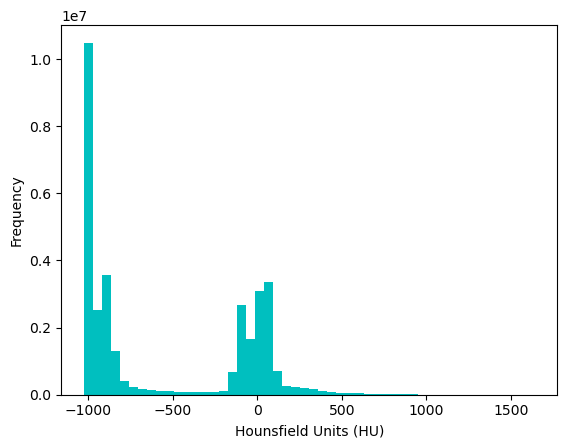

In [7]:
# displaying histogram based on HU
# histagram shows lots of air, some lung, lots of soft tissue (mostly muscle and liver, some fat), some bone
file_used=output_path+"/"+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

# flatten flattens the array: [[1,2], [3,4]] -> [1,2,3,4]
plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

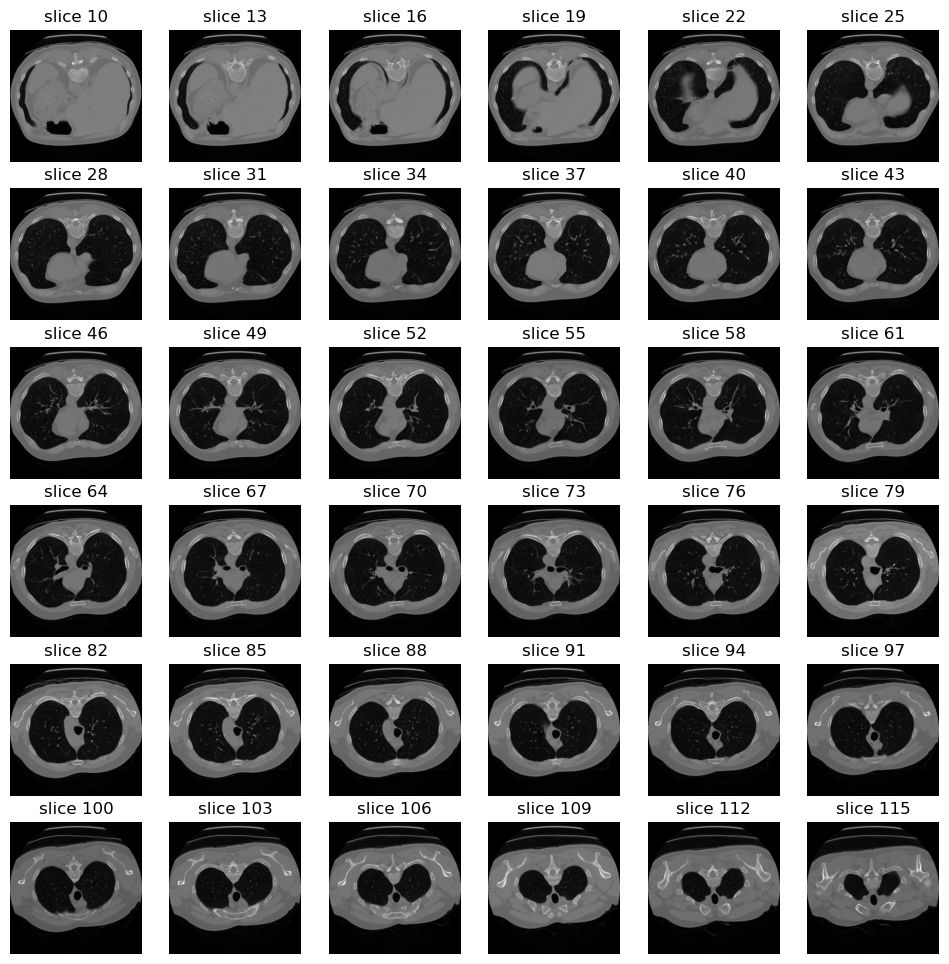

In [8]:
# displaying image stack
id = 0
imgs_to_process = np.flip(np.load(output_path + '/' + 'fullimages_{}.npy'.format(id)))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        # imshow: display data as image
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)